# Generative Models with Catalyst

Today we are going to learn about generative models.

We'll work with handwritten numbers, but we will generate with different models.

In [1]:
!pip install catalyst==21.06

In [4]:
import catalyst


catalyst.__version__

'21.06'

In [5]:
from catalyst.utils import get_device, set_global_seed


set_global_seed(42)
device = get_device()

We'll work with `MNIST` dataset. Download it, show examples of the writting and prepare the dataset to be loaded into models.

In [6]:
from catalyst.contrib.datasets import mnist


train = mnist.MNIST(".", train=True, download=True)
valid = mnist.MNIST(".", train=False, download=True)

In [7]:
train[0][0].shape

(28, 28)

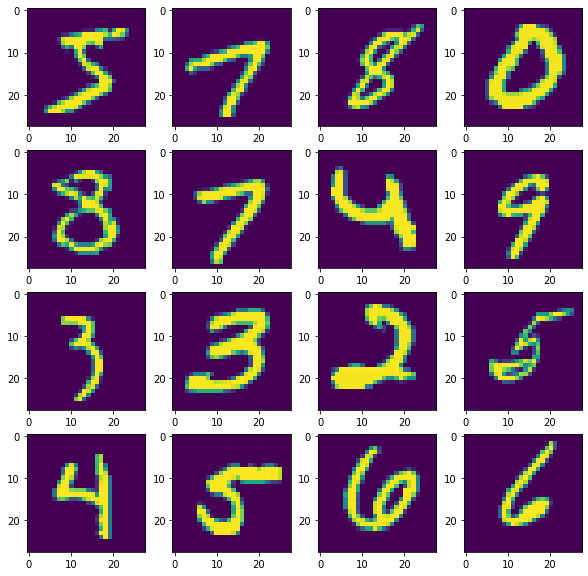

In [8]:
import matplotlib.pyplot as plt


%matplotlib inline

_, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(16):
    axs[i // 4][i % 4].imshow(train[100 * i + i][0])
plt.show()

In [9]:
import torch
import torch.nn as nn

In [10]:
import typing as tp

import numpy as np
from catalyst.utils import get_loader


batch_size = 1024
num_workers = 4


def transform(x: np.array) -> tp.Dict[str, torch.Tensor]:
    image = torch.FloatTensor(x["image"])
    image = torch.where(image > 127, torch.ones(image.shape), torch.zeros(image.shape))
    return {"image": image, "targets": x["targets"]}


train_data_loader = get_loader(
    train,
    open_fn=lambda x: {"image": x[0].reshape(1, 28, 28), "targets": x[1]},
    dict_transform=transform,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    sampler=None,
    drop_last=True,
)

valid_data_loader = get_loader(
    valid,
    open_fn=lambda x: {"image": x[0].reshape(1, 28, 28), "targets": x[1]},
    dict_transform=transform,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    sampler=None,
    drop_last=False,
)

## GAN

For GAN model, we need a Discriminator and a Generator. The Discriminator will judge generated images, how do they like real one. The Generator tries to fool the Discriminator.

Notice that Generator is similar to Decoder in AE/VAE perspective. It will required later.

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
        )
        self.clf = nn.Linear(64, 1)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(images)
        return self.clf(features)

In [14]:
big_numb = 7 ** 1000
big_numb

125325663996571831810755483238273420616498507508098617146349500752097059631738116432448839054351520763198615919551594076685828989467263022761790838270854579830015111246661203984624358929832571615718014704096305668097507613273663023226895250541385927158426088684494082416768617708189592286936039922311125683719215046689156738352590137241554510185855964549927575493247391132548534378497978806084951085874202011836362315727420109554782988791530088289711844550500230485638413189947132142243947334199259300735622492937419453650061490302105127920314430401636855677549136337481321811349678427076091437345045399337348611261168055929355402992823192491190360027036112283180935872775214517464013178274657100736321564606838252739601156414628445543663144696050650160812621814327062666195172701780200286645023823083185928061371310300829284071141207731280600001

In [15]:
from catalyst.contrib.nn.modules import Lambda


class Generator(nn.Module):
    def __init__(
        self,
        image_size: tp.Tuple[int, int] = (28, 28),
        latent_size: int = 10,
    ):
        super().__init__()

        self.image_size = image_size
        self.latent_size = latent_size

        self.map_generator = nn.Sequential(
            nn.Linear(latent_size, 64 * 49),
            Lambda(lambda x: x.view(x.size(0), 64, 7, 7)),
        )
        self.deconv = nn.Sequential(
            self.make_up_layer_(64, 16),  # 7 -> 14
            self.make_up_layer_(16, 4),  # 14 -> 28
        )

        self.output = nn.Sequential(nn.Conv2d(4, 1, 3, padding=1), nn.Sigmoid())

    def forward(self, points: torch.Tensor) -> torch.Tensor:
        feature_map = self.map_generator(points)
        feature_map = self.deconv(feature_map)
        return self.output(feature_map)

    def make_up_layer_(self, in_channels: int, out_channels: int) -> nn.Module:
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

To monitor decoded images, we have to write a new callback function. It will log image into the tensorboard.

In [17]:
from catalyst import dl
from catalyst.core import Callback, CallbackOrder


class LogFigureCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.External)

    def on_epoch_end(self, runner):
        logger = runner.loggers["_tensorboard"]
        logger = logger.loggers[runner.loader_key]
        logger.add_images(
            f"image/epoch",
            runner.output["generated_images"][:64],
            global_step=runner.global_epoch_step,
        )

Create model, criterion, optimizer. Train model!

In [19]:
from catalyst.contrib.nn.optimizers import RAdam


generator_1 = Generator()
discriminator = Discriminator()

model = {"generator": generator_1, "discriminator": discriminator}  # set models
optimizer = {
    "generator": RAdam(generator_1.parameters(), lr=3e-3, betas=(0.5, 0.999)),
    "discriminator": RAdam(discriminator.parameters(), lr=3e-3, betas=(0.5, 0.999)),
}  # set optimizers
criterion = nn.BCEWithLogitsLoss()
loaders = {
    "train": train_data_loader,
}

In [20]:
callbacks = [
    dl.OptimizerCallback(
        optimizer_key="generator", metric_key="loss_generator", model_key="generator"
    ),
    dl.OptimizerCallback(
        optimizer_key="discriminator", metric_key="loss_discriminator", model_key="discriminator"
    ),
    LogFigureCallback(),
]

Training process consists in two phases: discriminator and generator parts. The discriminator is differential metrics of 'fakeness'. So, it's trained to discriminate objects by `BinaryCrossEntropyLoss`. Because the discriminator is differential, we can pass knowledge about real images by backpropagation.

In [21]:
class GANRunner(dl.Runner):
    def handle_batch(self, batch: tp.Dict[str, torch.Tensor]):
        real_images = batch["image"]
        batch_metrics = {}
        latent_size = self.model["generator"].latent_size

        # Sample random points in the latent space
        batch_size = real_images.shape[0]
        random_latent_vectors = torch.randn(batch_size, latent_size).to(self.device)

        # Generate fake images by random points
        generated_images = self.model["generator"](random_latent_vectors).detach()
        # Combine them with real images
        combined_images = torch.cat([generated_images, real_images])

        # Assemble labels discriminating real from fake images
        labels = torch.cat([torch.ones((batch_size, 1)), torch.zeros((batch_size, 1))]).to(
            self.device
        )

        # Train the discriminator
        predictions = self.model["discriminator"](combined_images)
        batch_metrics["loss_discriminator"] = self.criterion(predictions, labels)

        # Sample random points in the latent space
        random_latent_vectors = torch.randn(batch_size, latent_size).to(self.device)
        # Assemble labels that say 'all real images'
        misleading_labels = torch.zeros((batch_size, 1)).to(self.device)

        # Train the generator
        generated_images = self.model["generator"](random_latent_vectors)
        self.output = {"generated_images": generated_images}
        predictions = self.model["discriminator"](generated_images)
        batch_metrics["loss_generator"] = self.criterion(predictions, misleading_labels)

        self.batch_metrics.update(**batch_metrics)


runner = GANRunner()

In [22]:
from datetime import datetime
from pathlib import Path


logdir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")

%reload_ext tensorboard
%tensorboard --logdir logs

In [23]:
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    callbacks=callbacks,
    num_epochs=30,
    verbose=True,
    logdir=logdir,
)

/opt/miniconda3/envs/ml-mipt/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


1/30 * Epoch (train):   0%|          | 0/58 [00:00<?, ?it/s]

AttributeError: 'DataParallel' object has no attribute 'latent_size'

## VAE-GAN

Remember that the Discriminator is a Decoder? Let's add an Encoder in our training rutin:

![](https://habrastorage.org/web/7a1/8db/d39/7a18dbd3969048c2b085cc707e539f0c.png)

It will make latent space meaningfull.

To train all these models, we need new loss function for encoder model. We need to compare results from the Discriminator with the real images. Instead from comparing images in the original sizes, we can compare feature maps from the Discriminator.


https://arxiv.org/pdf/1512.09300.pdf

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size: int = 10):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
        )
        self.latent_space = nn.Linear(64, 2 * latent_size)

        self.latent_size = latent_size

    def forward(self, images: torch.Tensor) -> tp.Tuple[torch.Tensor, torch.Tensor]:
        features = self.feature_extractor(images)
        latent = self.latent_space(features)
        return latent[:, : self.latent_size], latent[:, self.latent_size :]

In [ ]:
class Discriminator_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
        )
        self.clf = nn.Linear(64, 1)

    def forward(self, images: torch.Tensor) -> tp.Tuple[torch.Tensor, torch.Tensor]:
        features = self.feature_extractor(images)
        return self.clf(features), features

In [ ]:
class KLVAELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, loc: torch.Tensor, log_scale: torch.Tensor) -> torch.Tensor:
        return (-0.5 * torch.sum(log_scale - loc.pow(2) - log_scale.exp(), dim=1)).mean()

In [ ]:
encoder = Encoder()
generator_2 = Generator()
discriminator = Discriminator_v2()

model = {"generator": generator_2, "discriminator": discriminator, "encoder": encoder}  # set models
optimizer = {
    "generator": RAdam(generator_2.parameters(), lr=3e-3, betas=(0.5, 0.999)),
    "discriminator": RAdam(discriminator.parameters(), lr=3e-3, betas=(0.5, 0.999)),
    "encoder": RAdam(encoder.parameters(), lr=3e-3, betas=(0.5, 0.999)),
}  # set optimizers
criterion = {"bce": nn.BCEWithLogitsLoss(), "mse": nn.MSELoss(), "vae": KLVAELoss()}
loaders = {"train": train_data_loader}

In [ ]:
callbacks = [
    LogFigureCallback(),
]

Look the architecture and parameter update rutine:

Model Architecture:
![image](https://habrastorage.org/web/701/bbb/212/701bbb21273045fc9ed4aab7e0529764.png)

Parameter Updates:
![image](https://habrastorage.org/getpro/habr/post_images/07a/d0b/dc0/07ad0bdc0524f17cd4ae6c6e1be3c36d.svg)

What we need to code?

- Encoding training: compact latent space (KL Loss) and object reconstruction
- Discriminator training: discriminate real from fake and reconstructed
- Generator/decoder training: object reconstruction and fake object generator

In [ ]:
LOG_SCALE_MAX = 2
LOG_SCALE_MIN = -10


def normal_sample(loc: torch.Tensor, log_scale: torch.Tensor) -> torch.Tensor:
    scale = torch.exp(0.5 * log_scale)
    return loc + scale * torch.randn_like(scale)


class VAEGANRunner(dl.Runner):
    def _zero_grad(self):
        for optimizer in self.optimizer.values():
            optimizer.zero_grad()

    def handle_batch(self, batch: tp.Dict[str, torch.Tensor]):
        real_images = batch["image"]
        batch_metrics = {}
        latent_size = self.model["generator"].latent_size

        # encoder-decoder part
        latent_loc, latent_log_scale = self.model["encoder"](real_images)
        loss_prior = self.criterion["vae"](latent_loc, latent_log_scale)

        latent_log_scale = torch.clamp(latent_log_scale, LOG_SCALE_MIN, LOG_SCALE_MAX)
        latent_vectors = normal_sample(latent_loc, latent_log_scale)

        decoded_images = self.model["generator"](latent_vectors)

        _, predictions_decoded = self.model["discriminator"](decoded_images)
        _, predictions_real = self.model["discriminator"](real_images)
        loss_dislike = self.criterion["mse"](decoded_images, real_images)

        # generator part

        batch_size = real_images.shape[0]
        random_latent_vectors = torch.randn(batch_size, latent_size).to(self.device)

        generated_images = self.model["generator"](random_latent_vectors)

        combined_images = torch.cat([generated_images, decoded_images])
        labels = torch.zeros((2 * batch_size, 1)).to(self.device)

        self.output = {"generated_images": generated_images}
        predictions, _ = self.model["discriminator"](combined_images)
        loss_generator = self.criterion["bce"](predictions, labels)

        # discriminator part

        latent_vectors = normal_sample(latent_loc, latent_log_scale)
        random_latent_vectors = torch.randn(batch_size, latent_size).to(self.device)

        decoded_images = self.model["generator"](latent_vectors)
        generated_images = self.model["generator"](random_latent_vectors)

        combined_images = torch.cat([generated_images, decoded_images, real_images]).detach()
        labels = torch.cat([torch.ones((2 * batch_size, 1)), torch.zeros((batch_size, 1))]).to(
            self.device
        )
        predictions, _ = self.model["discriminator"](combined_images)
        loss_discriminator = self.criterion["bce"](predictions, labels)

        # closely look at the picture above and sum up losses for all part of VAE-GAN
        batch_metrics["loss_encoder"] = loss_prior + loss_dislike
        batch_metrics["loss_generator"] = loss_dislike + loss_generator
        batch_metrics["loss_discriminator"] = loss_discriminator
        if self.is_train_loader:
            batch_metrics["loss_encoder"].backward(retain_graph=True)
            optimizer["encoder"].step()
            self._zero_grad()

            batch_metrics["loss_generator"].backward(retain_graph=True)
            optimizer["generator"].step()
            self._zero_grad()

            batch_metrics["loss_discriminator"].backward()
            optimizer["discriminator"].step()
            self._zero_grad()

        self.batch_metrics.update(**batch_metrics)


runner = VAEGANRunner()

In [ ]:
logdir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    callbacks=callbacks,
    num_epochs=30,
    verbose=True,
    logdir=logdir,
)

How to compare models? Usually reseacher just closely look at the pictures. But they can use computer brains and eyes to compare generative models. Let's look at the one of them.

## Inception score

Wait, wat? We can create numerical metric for generative models? Yes, we can. The metric called Inception score. To calculate it, we need the image classificator and generated images. Let's do it.

\*Inception score usually calculates for generators, trained on ImageNet/CIFAR. But we have no time to train GAN on these datasets. So, we will work with MNIST.

In [ ]:
clf_model = nn.Sequential(nn.Flatten(), nn.Linear(28 * 28, 10)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = RAdam(clf_model.parameters(), lr=0.05)

runner = dl.SupervisedRunner(
    input_key="image",
    output_key="logits",
    target_key="targets",
)
runner.train(
    model=clf_model,
    optimizer=optimizer,
    criterion=criterion,
    callbacks=[dl.AccuracyCallback(input_key="logits", target_key="targets")],
    loaders={"train": train_data_loader, "valid": valid_data_loader},
    num_epochs=20,
    verbose=False,
    load_best_on_end=True,
)

Inception Score fomulating by this:

![](https://www.oreilly.com/library/view/generative-adversarial-networks/9781789136678/assets/0d33c46a-0a5f-4027-919c-30b910e6d93b.png)

where $p(y)$ – is probability of class in a dataset, $p(y|x)$ – is probability of class of object.

[Read more on IS](https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a)

In [ ]:
from tqdm.notebook import trange


def inception_score(model: nn.Module):
    p_y = torch.ones(10).to(device) / 10
    log_is = 0
    num_images = 50000
    batch_size = 100

    model.eval()
    with torch.no_grad():
        for _ in trange(num_images // batch_size):
            latent_size = model.latent_size
            random_latent_points = torch.randn((batch_size, latent_size)).to(device)
            generated = model(random_latent_points)
            logits = clf_model(generated)
            p_y_x = torch.softmax(logits, 1)
            log_is += (torch.log(p_y_x) * p_y_x - torch.log(p_y) * p_y_x).sum(1)

    log_is /= num_images
    return torch.exp(log_is.mean())

In [ ]:
inception_score(generator_1)

In [ ]:
inception_score(generator_2)

## (Additional) Another point in VAE - GAN: AAE

AAE stands for Adversarial Autoencoders. It is like a inverted VAE-GAN. A main model become AE, but we will use Discriminator to compare points in a latent space. Let's code it.

In [ ]:
class Disciriminator_v3(nn.Module):
    def __init__(self, latent_size: int = 4):
        super().__init__()

        self.latent_size = latent_size

        self.model = nn.Sequential(
            nn.Linear(latent_size, 100), nn.Dropout(0.1), nn.ReLU(), nn.Linear(100, 1), nn.Sigmoid()
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.model(z)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size: int = 10):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
        )
        self.latent_space = nn.Linear(64, latent_size)

        self.latent_size = latent_size

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(images)
        latent = self.latent_space(features)
        # Instead of VAE, AAE use simple encoder
        # because it can be trained by samples, not distributions.
        return latent

In [ ]:
class Decoder(nn.Module):
    def __init__(self, image_size: tp.Tuple[int, int] = (28, 28), latent_size: int = 10):
        super().__init__()

        self.image_size = image_size
        self.latent_size = latent_size

        self.map_generator = nn.Sequential(
            nn.Linear(latent_size, 64 * 49),
            Lambda(lambda x: x.view(x.size(0), 64, 7, 7)),
        )
        self.deconv = nn.Sequential(
            self.make_up_layer_(64, 16),  # 7 -> 14
            self.make_up_layer_(16, 4),  # 14 -> 28
        )

        self.output = nn.Sequential(nn.Conv2d(4, 1, 3, padding=1), nn.Sigmoid())

    def forward(self, points: torch.Tensor) -> torch.Tensor:
        feature_map = self.map_generator(points)
        feature_map = self.deconv(feature_map)
        return self.output(feature_map)

    def make_up_layer_(self, in_channels: int, out_channels: int) -> nn.Module:
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
        )

In [ ]:
class AE(nn.Module):
    def __init__(self, image_size: tp.Tuple[int, int] = (28, 28), latent_size: int = 4):
        super().__init__()

        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(image_size, latent_size)

    def forward(self, images: torch.Tensor) -> tp.Dict[str, torch.Tensor]:
        latent = self.encoder(images)
        x_ = self.decoder(latent)

        return {"decoder_result": x_, "latent": latent}

In [ ]:
autoencoder = AE()
discriminator = Disciriminator_v3()
model = {"autoencoder": autoencoder, "discriminator": discriminator}
optimizer = {
    "autoencoder": RAdam(autoencoder.parameters(), lr=1e-3),
    "discriminator": RAdam(discriminator.parameters(), lr=1e-4),
}
criterion = nn.BCELoss()

In [ ]:
callbacks = [LogFigureCallback()]

In [ ]:
class AAERunner(dl.Runner):
    def _zero_grad(self):
        for optimizer in self.optimizer.values():
            optimizer.zero_grad()

    def handle_batch(self, batch: tp.Dict[str, torch.Tensor]):
        real_images = batch["image"]
        batch_metrics = {}
        latent_size = self.model["discriminator"].latent_size
        batch_size = real_images.size(0)

        output = self.model["autoencoder"](real_images)
        fake_latent = output["latent"]
        decoded_images = output["decoder_result"]

        self.output = {"generated_images": decoded_images}
        normal_latent = torch.randn(fake_latent.size()).to(self.device)

        loss_ae = self.criterion(
            decoded_images.reshape(batch_size, -1), real_images.reshape(batch_size, -1)
        )

        concat_latent = torch.cat([normal_latent, fake_latent]).detach()
        target = torch.cat([torch.ones(batch_size), torch.zeros(batch_size)]).to(self.device)
        pred = self.model["discriminator"](concat_latent)
        batch_metrics["loss_discriminator"] = self.criterion(pred.reshape(-1), target)

        fake_pred = self.model["discriminator"](fake_latent)
        fake_target = torch.ones(batch_size).to(self.device)
        loss_fake_latent = self.criterion(fake_pred.reshape(-1), fake_target)

        batch_metrics["loss_autoencoder"] = loss_ae + loss_fake_latent

        if self.is_train_loader:
            optimizer["discriminator"].zero_grad()
            batch_metrics["loss_discriminator"].backward(retain_graph=True)
            optimizer["discriminator"].step()

            optimizer["autoencoder"].zero_grad()
            batch_metrics["loss_autoencoder"].backward()
            optimizer["autoencoder"].step()

        self.batch_metrics.update(**batch_metrics)


runner = AAERunner()

In [ ]:
logdir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    callbacks=callbacks,
    num_epochs=1000,
    verbose=True,
    logdir=logdir,
)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

**Cridentials**

Notebook origin is [Catalyst DL course](https://github.com/catalyst-team/dl-course)